# GRIB2 Reference Recipe for HRRR (High-Resolution Rapid Refresh)

This notebook example uses the `pangeo_forge_recipes.recipes.ReferenceRecipe` to create a reference index of the HRRR dataset. Since it is a `Kerchunk` based reference recipe, none of the source data files are transferred, only the `.json` `Kerchunk` index is copied over. 

For more background, see [this blog post](https://medium.com/pangeo/fake-it-until-you-make-it-reading-goes-netcdf4-data-on-aws-s3-as-zarr-for-rapid-data-access-61e33f8fe685).

The HRRR dataset is an atmospheric model produced by NOAA in near-real-time. The output model data are stored in the GRIB2 format, which is a common format in weather forecasting and modeling. By using the `Kerchunk`-based `pangeo_forge_recipes.recipes.ReferenceRecipe`, we can read this dataset as if it were `Zarr`. 


## Define the FilePattern

Here we will select some files from the HRRR data archive on the [AWS open data registry](https://registry.opendata.aws/noaa-hrrr-pds/). 

In [1]:

import fsspec 

# Initiate fsspec filesystems for reading and writing
fs = fsspec.filesystem('s3', anon=True, skip_instance_cache=True)

# retrieve list of available days in archive
days_available = fs.glob('s3://noaa-hrrr-bdp-pds/hrrr.*')

# Read HRRR GRIB2 files from latest day
files = fs.glob(f's3://{days_available[-1]}/conus/*wrfsfcf01.grib2')

# Append s3 prefix for filelist
files = sorted(['s3://'+f for f in files])
files

['s3://noaa-hrrr-bdp-pds/hrrr.20230127/conus/hrrr.t00z.wrfsfcf01.grib2',
 's3://noaa-hrrr-bdp-pds/hrrr.20230127/conus/hrrr.t01z.wrfsfcf01.grib2']

## Define the Recipe


As a first step in our recipe, we create a `File Pattern <../../recipe_user_guide/file_patterns>` to represent the input files.
In this case, since we already have a list of inputs, we just use the `pattern_from_file_sequence` convenience function.


In [4]:
from pangeo_forge_recipes.patterns import pattern_from_file_sequence
pattern = pattern_from_file_sequence(files, 'step', file_type='grib')


In [5]:
pattern

<FilePattern {'step': 2}>

In the `GribReferenceRecipe` class we can pass kwargs such as: `output_storage_options` and `grib_filter_by_keys`.

In [6]:
from pangeo_forge_recipes.recipes import ReferenceRecipe

data_filter={'typeOfLevel': 'heightAboveGround', 'level': [2, 10]}    
storage_options = {"anon": True}

recipe = ReferenceRecipe(pattern, storage_options=storage_options,grib_filters=data_filter)

recipe

ReferenceRecipe(file_pattern=<FilePattern {'step': 2}>, storage_config=StorageConfig(target=FSSpecTarget(fs=<fsspec.implementations.local.LocalFileSystem object at 0x10cd5f1f0>, root_path='/var/folders/mb/7d7yq_4j2qgdfm_j3j4tsyl40000gn/T/tmppo2sou07/DYsRved6'), cache=CacheFSSpecTarget(fs=<fsspec.implementations.local.LocalFileSystem object at 0x10cd5f1f0>, root_path='/var/folders/mb/7d7yq_4j2qgdfm_j3j4tsyl40000gn/T/tmppo2sou07/iej6tuaw'), metadata=MetadataTarget(fs=<fsspec.implementations.local.LocalFileSystem object at 0x10cd5f1f0>, root_path='/var/folders/mb/7d7yq_4j2qgdfm_j3j4tsyl40000gn/T/tmppo2sou07/So40UcNQ')), sha256=b'\xf9\xb55\xd0\xd5\x1d\xc8\\\x94e\xeaY:W\x9e_\xde\xdei\x94\xec\xfa}C\x85\xf0S\x9b\xb3a\xe4f', output_json_fname='reference.json', output_intake_yaml_fname='reference.yaml', storage_options={'anon': True}, target_options={}, inline_threshold=500, output_storage_options={}, concat_dims=[], identical_dims=[], coo_map={}, coo_dtypes={}, preprocess=None, postprocess=Non

## Storage

If the recipe excecution occurs in a Bakery, cloud storage will be assigned automatically.

For this example, we use the recipe's default storage, which is a temporary local directory.

## Execute recipe

For testing, we will use the `copy_pruned()` utility, which will create a subset of the recipe for testing.

In [7]:
recipe_pruned = recipe.copy_pruned()

Next we are converting the recipe to a python function for debugging.

In [8]:
rp = recipe_pruned.to_function()

In [9]:
rp()

/Users/nrhagen/opt/anaconda3/envs/install/envs/pangeo-forge-recipes/lib/python3.9/site-packages/kerchunk/combine.py:260: UserWarning: Concatenated coordinate 'step' contains less than expectednumber of values across the datasets: [1.]
  warnings.warn(


## Examine the Result

### Load with Intake

The easiest way to load the dataset created by `fsspec_reference_maker` is via intake.
An intake catalog is automatically created in the target.

In [10]:
cat_url = f"{recipe_pruned.target}/reference.yaml"
cat_url

'file:///var/folders/mb/7d7yq_4j2qgdfm_j3j4tsyl40000gn/T/tmppo2sou07/DYsRved6/reference.yaml'

In [11]:
import intake
cat = intake.open_catalog(cat_url)
cat

reference:
  args:
    path: file:///var/folders/mb/7d7yq_4j2qgdfm_j3j4tsyl40000gn/T/tmppo2sou07/DYsRved6/reference.yaml
  description: ''
  driver: intake.catalog.local.YAMLFileCatalog
  metadata: {}


To load the data lazily:

In [12]:
%time ds = cat.data.to_dask()
ds

CPU times: user 38.3 ms, sys: 5.62 ms, total: 43.9 ms
Wall time: 43.3 ms


<xarray.Dataset>
Dimensions:            (step: 1, y: 1059, x: 1799, heightAboveGround: 1,
                        time: 1, valid_time: 1)
Coordinates:
  * heightAboveGround  (heightAboveGround) int64 10
  * step               (step) timedelta64[ns] 01:00:00
  * time               (time) datetime64[ns] 2023-01-27
  * valid_time         (valid_time) datetime64[ns] 2023-01-27T01:00:00
Dimensions without coordinates: y, x
Data variables:
    d2m                (step, y, x) float64 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    latitude           (step, y, x) float64 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    longitude          (step, y, x) float64 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    pt                 (step, y, x) float64 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    r2                 (step, y, x) float64 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    sh2                (step, y, x) float64 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    si10               (step, y, x) float64 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    t2m                (step, y, x) float64 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    u10                (step, y, x) float64 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    unknown            (step, y, x) float64 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    v10                (step, y, x) float64 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
Attributes:
    centre:             kwbc
    centreDescription:  US National Weather Service - NCEP
    edition:            2
    subCentre:          0

### Manual Loading

It is also possible to load the reference dataset directly with xarray, bypassing intake.

In [13]:
ref_url = f"{recipe_pruned.target}/reference.json"
ref_url

'file:///var/folders/mb/7d7yq_4j2qgdfm_j3j4tsyl40000gn/T/tmppo2sou07/DYsRved6/reference.json'

In [14]:
import fsspec
import xarray as xr
m = fsspec.get_mapper(
    "reference://",
    fo=ref_url,
    target_protocol="file",
    remote_protocol="s3",
    remote_options=dict(anon=True),
    skip_instance_cache=True,
)
ds = xr.open_dataset(
    m,
    engine='zarr',
    backend_kwargs={'consolidated': False},
    chunks={},
    decode_coords="all"
)
ds

<xarray.Dataset>
Dimensions:            (step: 1, y: 1059, x: 1799, heightAboveGround: 1,
                        time: 1, valid_time: 1)
Coordinates:
  * heightAboveGround  (heightAboveGround) int64 10
  * step               (step) timedelta64[ns] 01:00:00
  * time               (time) datetime64[ns] 2023-01-27
  * valid_time         (valid_time) datetime64[ns] 2023-01-27T01:00:00
Dimensions without coordinates: y, x
Data variables:
    d2m                (step, y, x) float64 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    latitude           (step, y, x) float64 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    longitude          (step, y, x) float64 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    pt                 (step, y, x) float64 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    r2                 (step, y, x) float64 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    sh2                (step, y, x) float64 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    si10               (step, y, x) float64 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    t2m                (step, y, x) float64 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    u10                (step, y, x) float64 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    unknown            (step, y, x) float64 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    v10                (step, y, x) float64 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
Attributes:
    centre:             kwbc
    centreDescription:  US National Weather Service - NCEP
    edition:            2
    subCentre:          0

### Make a Map

Let's just verify that we can read an visualize the data. We'll compare the first year to the last year.

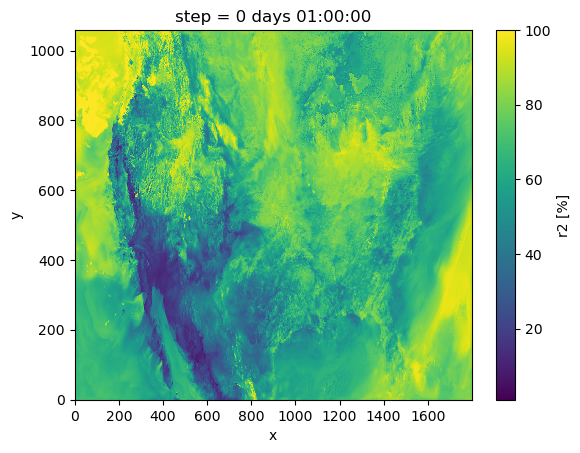

In [16]:
ds['r2'][-1].plot()